In [7]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
from pandas import DataFrame
ORIGINF = 5000 #Original frequency
FREQ=100 #Frequency after resampling (source freq: 5kHz, resampling 50x lower to 100Hz)

def get_stimlist(filename):
    """Opens file (text, name of file) in vmrk format, reads events and return list
    with tuples [(name_of_stimulus,stimulus_data_point)]"""
    with open(filename,'r') as file:
        data = file.read()
    stimlist=[n for n in data.split('\n') if 'Stimulus' in n]
    return [(n.split(',')[1],int(n.split(',')[2])) for n in stimlist]

def get_stimulus_array(stimlist):
    """Export array of stimuli data poitns from stimlist"""
    return np.array(stimlist)[:,1].astype(int)

def get_stimulus_names(stimlist):
    """Export array of stimuli names from stimlist"""
    return np.array(stimlist)[:,0]

def resample_events(stim_array,resample_coef=50):
    """Resample events using given coefficient, accepts 
    returns numpy array with rounded resampled stimulus."""
    return np.round(stim_array/resample_coef).astype(int)


Plan for original analysis:The signal was resampled into 1000Hz, then smoothed with median (100 samples), and filtered with a high-passed 1Hz filter. We calculated normalized change in SCL with equation 100✕(SCLStim-SCLbaseline/SCLbaseline), where SCLStim is the mean signal value during the stimulus and SCLbaseline is an SCL reaction during the baseline preceding the first part in each scenario (Sugimine et al. 2020).

In [10]:
data = mne.io.read_raw_brainvision('analiza_treatment/JM22a_B252_tp5.vhdr')
resampled = data.copy().resample(sfreq=FREQ).get_data().flatten()
filtered = mne.filter.filter_data(resampled,100,None,2)
medfiltered=medfilt(filtered,49)



Extracting parameters from analiza_treatment/JM22a_B252_tp5.vhdr...
Setting channel info structure...
Setting up low-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [12]:
stimlist = get_stimlist('analiza_treatment/JM22a_B252_tp5.vmrk')
stimarr = get_stimulus_array(stimlist)
new_stims= resample_events(stimarr,ORIGINF/FREQ)


(8e-06, 1.4e-05)

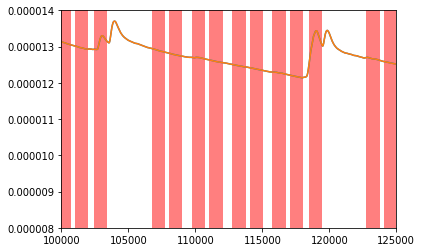

In [15]:


plt.plot([n for n in range(0,len(filtered),1)],filtered)

plt.plot([n for n in range(0,len(medfiltered),1)],medfiltered)
#plot each stimulus
for stim in new_stims:
    plt.axvspan(stim-500, stim+500, facecolor='r',alpha=0.5)


(50000, 10000)

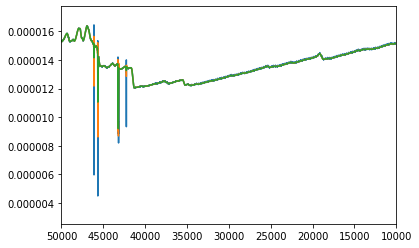

In [19]:
# #Plottting, if needed

#plot resampled raw data
plt.plot([n for n in range(0,len(resampled),1)],resampled)

#plot data filtered with low-pass filter
plt.plot([n for n in range(0,len(filtered),1)],filtered)

#plot data filtered with median filter
plt.plot([n for n in range(0,len(medfiltered),1)],medfiltered)


#plot each stimulus
for stim in new_stims:
    plt.axvspan(stim-500, stim+500, facecolor='r',alpha=0.5)

    
plt.xlim(50000,10000)
# plt.ylim(.000008,.000014)

In [109]:
result = []
for name,datapoint in zip(stimnames,new_stims):
    tmp_bsle=np.mean(filtered[datapoint-(3*FREQ):datapoint])*1000000
    tmp_mean30=np.mean(filtered[datapoint:datapoint+(30*FREQ)])*1000000
    tmp_mean15=np.mean(filtered[datapoint:datapoint+(15*FREQ)])*1000000
    tmp_mean12=np.mean(filtered[datapoint:datapoint+(12*FREQ)])*1000000
    
    tmp_bsle=np.min(filtered[datapoint-(3*FREQ):datapoint])*1000000
    tmp_min30=np.min(filtered[datapoint:datapoint+(30*FREQ)])*1000000
    tmp_min15=np.min(filtered[datapoint:datapoint+(15*FREQ)])*1000000
    tmp_min12=np.min(filtered[datapoint:datapoint+(12*FREQ)])*1000000
    
    tmp_bsle=np.max(filtered[datapoint-(3*FREQ):datapoint])*1000000
    tmp_max30=np.max(filtered[datapoint:datapoint+(30*FREQ)])*1000000
    tmp_max15=np.max(filtered[datapoint:datapoint+(15*FREQ)])*1000000
    tmp_max12=np.max(filtered[datapoint:datapoint+(12*FREQ)])*1000000
    
    result.append((f'{name}_baseline',tmp_bsle))
    result.append((f'{name}_mean30',tmp_mean30))
    result.append((f'{name}_mean15',tmp_mean15))
    result.append((f'{name}_mean12',tmp_mean12))
    result.append((f'{name}_min30',tmp_min30))
    result.append((f'{name}_min15',tmp_min15))
    result.append((f'{name}_min12',tmp_min12))
    result.append((f'{name}_max30',tmp_max30))
    result.append((f'{name}_max15',tmp_max15))
    result.append((f'{name}_max12',tmp_max12))
DataFrame(result).to_excel('output.xlsx')